In [2]:
# importing the required libraries
import numpy as np
from matplotlib import pyplot as plt 
import os
import json
import requests
import datetime
from IPython.display import HTML, display

In [3]:
# function to extract the required PIDs from the string LABELS
def extract_PID_data(data, PROTOCOL,LABEL):
    
    if (PROTOCOL == 'SAE'):

        if LABEL == 'ENGINE LOAD': # Engine Load
            PID_TAG = 'spn_92_avg'
        elif LABEL == 'ENGINE RPM': # Engine Speed (RPM)
            PID_TAG = 'spn_190_avg'
        elif LABEL == 'DPFDP': # DPF Diffrential Pressure (across DPF)
            PID_TAG = 'spn_3251_avg'
        elif LABEL == 'SPEED': # Wheep based Vehicle Speed
            PID_TAG = 'spn_84_avg'
        elif LABEL == 'DPFINT':# DPF in Temperature Before DPF (DOC out)
            PID_TAG = 'spn_3250_avg' 
        elif LABEL == 'SOOTLOAD_3719': #  Soot load  
            PID_TAG = 'spn_3719_avg' 
        elif LABEL == 'SOOTLOAD_5466': # Soot load (Regen threshold)    
            PID_TAG = 'spn_5466_avg'      
        elif LABEL == 'ACTIVEREGEN':  # Regen status
            PID_TAG = 'spn_3700_avg' 
                  

    Time_vec = []
    Val_vec = []
    
    for data_cnt in range(0,len(data)):
        if "pids" in data[data_cnt]:
            if len(data[data_cnt]['pids'])>0:
                for sub_pid_cnt in range(0,len(data[data_cnt]['pids'])):  #this loop
                    State = data[data_cnt]['pids'][sub_pid_cnt]
                    if PID_TAG in State:
                        #print("--------------------------------------------IN----------------------------------")
                        Time_vec.append(np.array(State[PID_TAG]['timestamp'], dtype=np.int64))
                        Val_vec.append(np.array(State[PID_TAG]['value'], dtype=float))
      
    return Time_vec,Val_vec

In [4]:
def miliseconds_to_utc(time_ms):
    time_seconds = time_ms / 1000.0
    # Create a UTC datetime object
    trip_time_utc = datetime.datetime.utcfromtimestamp(time_seconds).replace(
        tzinfo=datetime.timezone.utc
    )
    formatted_trip_time_utc = trip_time_utc.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

    return formatted_trip_time_utc

In [5]:
# this function checks whether all the values in an array lies in the range of [min_val, max_val]
def check_range(arr, min_val, max_val):
    return all(min_val <= x <= max_val for x in arr)

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [7]:
import pandas as pd

In [8]:
# function to find regen zone
def REGEN_ZONE(DPFINT_data, DPFINT_Time, ACTIVE_REGEN_data):

    regen_start_idx = "NA"
    regen_end_idx = "NA"
    i = 0
    while i < len(DPFINT_data):
        if DPFINT_data[i]>=500 and ACTIVE_REGEN_data[i] == 1:
            print(i)
            regen_start_idx = i    
            for j in range(i+1, len(DPFINT_data)): 
                if DPFINT_data[j]>=350 and ACTIVE_REGEN_data[j] == 1:
                    regen_end_idx = j
                else:
                    break        
        if regen_start_idx!='NA' and regen_end_idx!='NA':
            break
        elif regen_start_idx!='NA' and  regen_end_idx=='NA':
             i = j+1
        else:
            i+=1      
                        
                   
    return DPFINT_Time[regen_start_idx], DPFINT_Time[regen_end_idx]           


In [173]:
def active_regeneration_signal(SOOTLOAD_5466_data, SOOTLOAD_5466_Time, active_regeneration_start_time):
       
        
        # if soot load values are available --> find the point where maximum negative slope present
        slope = np.array(SOOTLOAD_5466_data[1:-1]) - np.array(SOOTLOAD_5466_data[0:-2])

        # get the point where we get the maximum drop in the slope of 5466
        min_point_index_5466 = np.argmin(slope)
        
        # finding the nearest soot-load time index
        _, SL_nearest_start_time_idx = find_nearest(SOOTLOAD_5466_Time, active_regeneration_start_time)

        # checking whether the point of drop in soot-load (PID 5466) value and active regeneration- end point are in vicinity 
        if (min_point_index_5466 - SL_nearest_start_time_idx)**2 <=25:
                return "5466"                 
        else:
                return "3719"                

      
                                      


In [10]:
# function to perform the validation of data
def DBQ_VALIDATION(OBD_data):
    
    validation_status = 'PASSED'

    # validation for differential pressure
    LABEL = 'DPFDP'
    min_DP_val = 0    
    max_DP_val = 70
    DPFDP_Time, DPFDP_Value = extract_PID_data(OBD_data,'SAE',LABEL)

    reason_of_failure = ""

    # if no values present for the given PID
    if len(DPFDP_Value) == 0:
        validation_status = 'FAILED'
        reason_of_failure += "PID 3251 DPF-Differential Pressure is not present\n "

    # if values prsent for the PID
    elif (len(DPFDP_Value) != 0):
        # checking if the values prsent lie beyond the particular range and whether the variance is not constant 
        if (not check_range(DPFDP_Value, min_DP_val, max_DP_val)):
            validation_status = 'FAILED'
            reason_of_failure += "PID 3251 DPF-Differential Pressure is out of its ideal range\n "
              
        elif ((np.std(DPFDP_Value) < 0.1*np.max(DPFDP_Value))) or (np.std(DPFDP_Value))==0:
                validation_status = 'FAILED'
                reason_of_failure += "PID 3251 DPF-Differential Pressure doesn't have sufficient variance\n "
            
    TS = []
    for cnt in range(0,len(DPFDP_Time)):
        TEMP = datetime.datetime.fromtimestamp((DPFDP_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 1)
    plt.plot(TS,DPFDP_Value,'.b')
    plt.title(LABEL)
       
    # validation for the DPFIN temperature
    LABEL = 'DPFINT'
    min_DPFINT_val = 0    
    max_DPFINT_val = 700
    DPFINT_Time, DPFINT_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    # if no values present for the given PID
    if (len(DPFINT_Value) == 0):
        validation_status = 'FAILED'
        reason_of_failure += "PID 3250 DPF-Inlet Temperature is not present\n "

    # checking if the values prsent lie beyond the particular range and whether the variance is not constant 
    elif (len(DPFINT_Value) != 0):
        # checking if the values present lie beyond the particular range and whether the variance is not constant
        if (not check_range(DPFINT_Value, min_DPFINT_val, max_DPFINT_val)):
            validation_status ='FAILED'
            reason_of_failure += "PID 3250 DPF-Inlet Temperature is out of its ideal range\n "
             
        elif (np.std(DPFINT_Value) < 0.1*np.max(DPFINT_Value)) or np.std(DPFINT_Value)==0:
                validation_status ='FAILED'
                reason_of_failure += "PID 3250 DPF-Inlet Temperature doesn't have sufficient variance\n "
    TS = []
    for cnt in range(0,len(DPFINT_Time)):
        TEMP = datetime.datetime.fromtimestamp((DPFINT_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 2)
    plt.plot(TS,DPFINT_Value,'.b')
    plt.title(LABEL)

    # validation for the Engine RPM
    LABEL = 'ENGINE RPM'
    min_RPM_val = 0    
    max_RPM_val = 3500
    RPM_Time, RPM_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    if (len(RPM_Value) == 0):
        validation_status = 'FAILED'
        reason_of_failure += "PID 190 Engine RPM is not present\n "
    
    # checking if the values prsent lie beyond the particular range and whether the variance is not constant 
    elif (len(RPM_Value) != 0):
        if (not check_range(RPM_Value, min_RPM_val, max_RPM_val)):
           validation_status = 'FAILED'
           reason_of_failure += "PID 190 Engine RPM is out of its ideal range\n "  
        
        elif (np.std(RPM_Value) < 0.1*np.max(RPM_Value)) or np.std(RPM_Value)==0:
                validation_status = 'FAILED'
                reason_of_failure += "PID 190 Engine RPM doesn't have sufficient variance\n "
    TS = []
    for cnt in range(0,len(RPM_Time)):
        TEMP = datetime.datetime.fromtimestamp((RPM_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 3)
    plt.plot(TS,RPM_Value,'.b')
    plt.title(LABEL)

    # validation for LOAD
    LABEL = 'ENGINE LOAD'
    min_LOAD_val = 0    
    max_LOAD_val = 100
    LOAD_Time, LOAD_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    
    if (len(LOAD_Value) == 0):
        validation_status = 'FAILED'
        reason_of_failure += "PID 92 Engine Load is not present,\n "

    elif (len(LOAD_Value) != 0):
        if (not check_range(LOAD_Value, min_LOAD_val, max_LOAD_val)):
            validation_status = 'FAILED'
            reason_of_failure += "PID 92 Engine Load is out of its ideal range,\n "
        elif (np.std(LOAD_Value) < 0.1*np.max(LOAD_Value)) or np.std(LOAD_Value)==0:
                validation_status = 'FAILED'
                reason_of_failure += "PID 92 Engine Load doesn't have sufficient variance\n"
    TS = []
    for cnt in range(0,len(LOAD_Time)):
        TEMP = datetime.datetime.fromtimestamp((LOAD_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 4)
    plt.plot(TS,LOAD_Value,'.b')
    plt.title(LABEL)
    
    # validation for the veichle speed
    LABEL = 'SPEED'
    min_SPEED_val = 0    
    max_SPEED_val = 300
    SPEED_Time, SPEED_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    if (len(SPEED_Value) == 0):
        validation_status = 'FAILED'
        reason_of_failure += "PID 84 SPEED is not available,\n "

    elif (len(SPEED_Value) != 0):
        if (not check_range(SPEED_Value, min_SPEED_val, max_SPEED_val)):
            validation_status = 'FAILED'
            reason_of_failure += "PID 84 Speed is out of its ideal range\n "
        elif (np.std(SPEED_Value) < 0.1*np.max(SPEED_Value)) or np.std(SPEED_Value)==0:
                validation_status = 'FAILED'
                reason_of_failure += "PID 84 Speed doesn't have sufficient variance\n "
    TS = []
    for cnt in range(0,len(SPEED_Time)):
        TEMP = datetime.datetime.fromtimestamp((SPEED_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 5)
    plt.plot(TS,SPEED_Value,'.b')
    plt.title(LABEL)
    
     # validation for Soot Load 3719
    LABEL = 'SOOTLOAD_3719'
    SL_3719_Time, SL_3719_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    min_SL_val = 0    
    max_SL_val = 250
    if (len(SL_3719_Value) == 0):
        print('SOOTLOAD_3719 NOT AVAILABLE')
    else:
        if(not check_range(SL_3719_Value, min_SL_val, max_SL_val)):
            print('SOOTLOAD_3719 AVAILABLE BUT NOT ACCEPTED RANGE')
        elif(np.std(SL_3719_Value) < 0.1*np.max(SL_3719_Value)):
                print('SOOTLOAD_3719 AVAILABLE BUT CONSTANT VALUE')
    TS = []
    for cnt in range(0,len(SL_3719_Time)):
        TEMP = datetime.datetime.fromtimestamp((SL_3719_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 6)
    plt.plot(TS,SL_3719_Value,'.b')
    plt.title(LABEL)  

     # validation for Soot Load 5466
    LABEL = 'SOOTLOAD_5466'
    SL_5466_Time, SL_5466_Value = extract_PID_data(OBD_data,'SAE',LABEL)
    min_SL_val = 0    
    max_SL_val = 250
    if (len(SL_5466_Value) == 0):
        print('SOOTLOAD_5466 NOT AVAILABLE')
    else:
        if (not check_range(SL_5466_Value, min_SL_val, max_SL_val)):
            print('SOOTLOAD_5466 AVAILABLE BUT NOT ACCEPTED RANGE')
        elif(np.std(SL_5466_Value) < 0.1*np.max(SL_5466_Value)):
                print('SOOTLOAD_5466 AVAILABLE BUT CONSTANT VALUE')
    TS = []
    for cnt in range(0,len(SL_5466_Time)):
        TEMP = datetime.datetime.fromtimestamp((SL_5466_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 7)
    plt.plot(TS,SL_5466_Value,'.b')
    plt.title(LABEL)
    
    # validation for Active Regen status signal
    LABEL = 'ACTIVEREGEN'
    AR_Time, AR_Value = extract_PID_data(OBD_data,'SAE',LABEL)    
    if len(AR_Value) == 0 :
        print('ACTIVE REGEN NOT AVAILABLE')
    else:
        print('ACTIVE REGEN AVAILABLE')  

    TS = []
    for cnt in range(0,len(AR_Time)):
        TEMP = datetime.datetime.fromtimestamp((AR_Time[cnt] + 19800*1000) / 1000.0, tz=datetime.timezone.utc)
        TS.append(TEMP)
        
    plt.subplot(8, 1, 8)
    plt.plot(TS,AR_Value,'.b')
    plt.title(LABEL)
              

    if validation_status == 'PASSED':
        markdown_cell = """
        <span style="color: green"><b>PASSED</b></span>
        """
        display(HTML(markdown_cell))
    else:
        markdown_cell = """
        <span style="color: red"><b>FAILED</b></span>
        """
        display(HTML(markdown_cell))
        failure_reason =""" <span style="color: red"><b>REASON_OF_FAILURE:</b> </span>"""
        display(HTML(failure_reason))
        print(reason_of_failure)

    plt.show()


    return validation_status


               



ENTER YOUR INPUTS IN THE BELOW GIVEN 
specify three parameters as input
- vehicle_id
- Start_TS : Start period from which we want the data  (Start time should be after the FOTA is being performed)
- End_TS : End period till which we want the data
- country_FLAG is US (for USA vehicles) or country_FLAG is IN (for INDIAN vehicles) 

In [167]:
# getting the vehicle associated parameters
# specify three parameters as input
# vehicle_id
# Start_TS : Start period from which we want the data  (Start time should be after the FOTA is being performed)
# End_TS : End period till which we want the data
# country_FLAG is US or country_FLAG is IN 
vehicle_id = '1288662121478881280'
Start_TS =  1722556800000
End_TS =   1722729540000
country_FLAG = 'US'

if country_FLAG == 'US':
    OBD_data_path = 'https://old-data-downloader.intangles-aws-us-east-1.intangles.us/download/' + str(vehicle_id) +  "/" + str(Start_TS) + "/" + str(End_TS)
elif country_FLAG == 'IN':
    OBD_data_path = 'http://data-download.intangles.com:1883/download/' + str(vehicle_id) +  "/" + str(Start_TS) + "/" + str(End_TS) 
r = requests.get(OBD_data_path, stream=True)
OBD_data = r.json()      

ACTIVE REGEN AVAILABLE


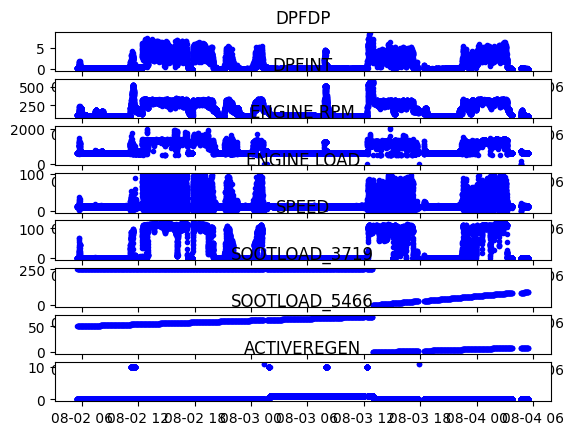

In [168]:
validation_status = DBQ_VALIDATION(OBD_data)



### Commenting on which SOOT LOad signal can be used

In [174]:
if validation_status == 'PASSED':
    # extracting the required PIDs
    DPFINT_Time, DPFINT_Value = extract_PID_data(OBD_data,'SAE','DPFINT')
    ACTIVE_REGEN_Time, ACTIVE_REGEN_Value = extract_PID_data(OBD_data,'SAE','ACTIVEREGEN')
    SL_5466_Time, SL_5466_Value = extract_PID_data(OBD_data,'SAE','SOOTLOAD_5466')
    # getting the start and end regeneration time
    start_regen_time, end_regen_time = REGEN_ZONE(DPFINT_Value, DPFINT_Time, ACTIVE_REGEN_Value)
    if start_regen_time!='NA' and end_regen_time!='NA':
        # getting the nearest start and end regeneartion times in SOOT-LOAD signals 
        SL_nearest_start_time, SL_nearest_start_time_idx = find_nearest(SL_5466_Time, start_regen_time)
        SL_nearest_end_time, SL_nearest_end_time_idx = find_nearest(SL_5466_Time, end_regen_time)
        print(active_regeneration_signal(SL_5466_Value[SL_nearest_start_time_idx: SL_nearest_end_time_idx+25], 
                                          SL_5466_Time[SL_nearest_start_time_idx: SL_nearest_end_time_idx+25],             
                                          SL_5466_Time[SL_nearest_end_time_idx]) + " PID" + " for SOOT LOAD signal")
    else:
        print("Regeneartion hasn't happened yet can't comment on soot load")    
else:
    print("DATA is invalid, can't comment on Soot-Load PID")     


10914
5466 PID for SOOT LOAD signal


-----------------------------------------------------------------------------------------------------------------------------------

In [158]:
start_regen_time, end_regen_time = REGEN_ZONE(DPFINT_Value, DPFINT_Time, ACTIVE_REGEN_Value)

1094


In [159]:
_, sidx = find_nearest(DPFINT_Time, start_regen_time)
_, eidx = find_nearest(DPFINT_Time, end_regen_time)

In [160]:
print(DPFINT_Value[sidx-1: eidx+2])
print(ACTIVE_REGEN_Value[sidx-1: eidx+2])
print(DPFINT_Time[sidx-1: eidx+2])

[array([484.8125]), array([500.3125]), array([513.53125]), array([523.5]), array([531.03125]), array([536.3125]), array([538.59375]), array([541.09375]), array([543.75]), array([542.625]), array([534.75]), array([531.46875]), array([532.5]), array([530.]), array([530.3125]), array([531.15625]), array([530.96875]), array([530.6875]), array([529.5]), array([531.84375]), array([530.71875]), array([529.21875]), array([533.8125]), array([527.1875]), array([521.1875]), array([513.90625]), array([511.0625]), array([516.375]), array([525.8125]), array([535.5625]), array([534.8125]), array([528.3125]), array([523.75]), array([530.25]), array([538.]), array([527.8125]), array([527.21875]), array([528.75]), array([530.09375]), array([537.3125]), array([544.375]), array([542.5625]), array([536.90625]), array([533.34375]), array([535.15625]), array([540.]), array([543.15625]), array([546.0625]), array([542.53125]), array([539.59375]), array([540.0625]), array([542.1875]), array([545.15625]), array(

In [161]:
print(start_regen_time, end_regen_time)
SL_nearest_start_time, SL_nearest_start_time_idx = find_nearest(SL_5466_Time, start_regen_time)
print(SL_nearest_start_time)
SL_nearest_end_time, SL_nearest_end_time_idx = find_nearest(SL_5466_Time, end_regen_time)
if SL_nearest_start_time == SL_nearest_end_time:
    SL_nearest_end_time += 1

1722479413500 1722481605250
1722479413500


In [162]:
avg_AR_freq = sum(AR_freq)/len(AR_freq)
avg_DPFINT_freq = sum(DPFINT_freq)/len(DPFINT_freq)
avg_SL_freq = sum(SL_5466_freq)/len(SL_5466_freq)

In [163]:
_, one_hour_before_regen = find_nearest(SL_5466_Time,SL_nearest_start_time - 1*60*60*1000)
_, one_hour_after_regen = find_nearest(SL_5466_Time,SL_nearest_end_time + 1*60*60*1000)
SL_5466_Value[one_hour_before_regen: one_hour_after_regen]

[array([99.53]),
 array([99.5325]),
 array([99.535]),
 array([99.5375]),
 array([99.5375]),
 array([99.54]),
 array([99.5425]),
 array([99.5475]),
 array([99.55]),
 array([99.55]),
 array([99.5525]),
 array([99.555]),
 array([99.5575]),
 array([99.56]),
 array([99.56]),
 array([99.5625]),
 array([99.565]),
 array([99.5675]),
 array([99.5675]),
 array([99.5725]),
 array([99.575]),
 array([99.5775]),
 array([99.58]),
 array([99.58]),
 array([99.5825]),
 array([99.585]),
 array([99.5875]),
 array([99.5875]),
 array([99.59]),
 array([99.5925]),
 array([99.595]),
 array([99.6]),
 array([99.6025]),
 array([99.6025]),
 array([99.605]),
 array([99.6075]),
 array([99.61]),
 array([99.61]),
 array([99.6125]),
 array([99.615]),
 array([99.6175]),
 array([99.6175]),
 array([99.62]),
 array([99.625]),
 array([99.6275]),
 array([99.63]),
 array([99.6325]),
 array([99.6325]),
 array([99.635]),
 array([99.6375]),
 array([99.64]),
 array([99.64]),
 array([99.6425]),
 array([99.645]),
 array([99.6475]),

In [164]:
start_regen_time_idx, end_regen_time_idx = REGEN_ZONE(DPFINT_Value, DPFINT_Time, ACTIVE_REGEN_Value)
if validation_status == 'PASSED':
    if start_regen_time_idx!='NA' and end_regen_time_idx!='NA':
        #one_hour_before_regen
        print(active_regeneration_signal(SL_5466_Value[SL_nearest_start_time_idx: SL_nearest_end_time_idx+25], 
                                          SL_5466_Time[SL_nearest_start_time_idx: SL_nearest_end_time_idx+25],             
                                          SL_5466_Time[SL_nearest_end_time_idx]))
        # print(active_regeneration_signal(SL_5466_Value[one_hour_before_regen: one_hour_after_regen], 
        #                                   SL_5466_Time[one_hour_before_regen: one_hour_after_regen],             
        #                                   SL_5466_Time[SL_nearest_start_time_idx]))
    else:
        print("No regeneration observed yet")        
else:
    print("DATA is invalid, can't comment on Soot-Load Signal")  


1094
[array([35.4875]), array([35.435]), array([35.445]), array([35.4725]), array([35.515]), array([35.6]), array([35.6475]), array([35.7175]), array([35.845]), array([36.45]), array([36.6825]), array([36.5975]), array([36.4875]), array([36.3375]), array([36.235]), array([36.1675]), array([36.1325]), array([36.115]), array([36.01]), array([35.935]), array([35.915]), array([35.9075]), array([35.9475]), array([36.27]), array([36.7475]), array([37.03]), array([37.18]), array([37.17]), array([36.93]), array([36.7725]), array([36.895]), array([36.9425]), array([36.795]), array([36.6025]), array([36.735]), array([36.73]), array([36.8575]), array([36.9475]), array([36.7925]), array([36.625]), array([36.5625]), array([36.6025]), array([36.6475]), array([36.6925]), array([36.705]), array([36.7025]), array([36.4275]), array([36.5175]), array([36.565]), array([36.7325]), array([36.8575]), array([36.72]), array([36.6425]), array([36.6425]), array([36.77]), array([36.9425]), array([36.84]), array([